![](../header.jpg)

# Stereo Odometry [still work in progress]

## Data Sets

Data from [KITTI](http://www.cvlibs.net/datasets/kitti/setup.php). If you go to the [Odometry page](http://www.cvlibs.net/datasets/kitti/eval_odometry.php) and download the following data sets (direct links are below): 

- [grayscale (22GB)](http://www.cvlibs.net/download.php?file=data_odometry_gray.zip)
- [calibration (1MB)](http://www.cvlibs.net/download.php?file=data_odometry_calib.zip)
- [ground truth (4MB)](http://www.cvlibs.net/download.php?file=data_odometry_poses.zip)

Note, the video is **big** and why I don't provide a copy of it.

https://cs-people.bu.edu/ainezm/cs585-FinalProj-sidmys-ainezm.html

1. For each iteration, $k$ starting with $k=1$ (the 2nd image), read the current stereo pair: $I_{l,k}$ and $I_{r,k}$
1. Match and triangulate features between $I_{l,k}$ and $I_{r,k}$
1. Match the matched features against $I_{l,k-1}$ to get a list of correspondences between the previous frame and the current stereo pair - this gives us a list of features that are tracked between the consecutive frames.
1. Compute the optical flow, $\dot{p}$ between $I_{l,k}$ and $I_{l,k-1}$ as $\dot{p} = K^{-1}(p_{l,k} - p_{l,k-1})$
1. Using triangulation from (2), compute rotational and translational velocity (see below for details)
1. The velocity will be in the current camera frame ($I_{l,k}$) and needs to be cast to the previous frame using rotation $R_k^{k-1}$ which has a ZXY Euler roll, pitch and yaw defined by $\Delta \Omega^k = dt\cdot \dot{\Omega}_k^{k-1}$ where $\Omega = [roll, pitch, yaw]^\top$. This gives us $v^{k-1} = R_k^{k-1} v^{k}$ and $\Delta \Omega^{k-1} = R_k^{k-1}\Delta\Omega^{k}$. Finally, this is cast back to the world-coordinate frame by $v^{0} = R_{k-1}^0 v^{k-1}$ and $\Delta \Omega^0 = R_{k-1}^0 \Delta \Omega^{k-1}$
1. The Pose at instance $k$ is then cmputed as $X_k^0 = X_{k-1}^0 + dt \cdot v_k^0$ and $\Omega_k^0 = \Omega_{k-1}^0 + dt \cdot \Delta \Omega_k^0$
1. Repeat from (1) for $k = k+1$


looks good: https://github.com/cgarg92/Stereo-visual-odometry

good overview: https://www.cs.toronto.edu/~urtasun/courses/CSC2541/03_odometry.pdf

In [1]:
%load_ext autoreload
%autoreload 2

In [134]:
import cv2          # opencv itself
import numpy as np  # matrix manipulations
import os           # file stuff

# to play an mpeg4 video, you can do this:
# from IPython.display import HTML # need this for embedding a movie in an iframe
from matplotlib import pyplot as plt
from ipywidgets import Video
from tqdm import tqdm

import pykitti2 as pykitti  # this is a modified version of the original, I don't load the lidar data
from pykitti2.utils import rotz

from helper import ll2xy
from helper import imshow
from helper import videoWriter
from helper import plotSensors, printCameraParams
from helper import gray2rgb
from pykitti2.utils import rotz

rad2deg = 180.0/np.pi
np.set_printoptions(suppress=True)

## Sensor Layout

<img src="setup.png" width="85%">

## Video

As shown in the diagram above, there are two sets of cameras: Point Grey Flea 2 (FL-14S3M-C) 1.4 Megapixel grayscale (0 and 1) and Point Grey Flea 2 (FL-14S3C-C) 1.4 Megapixel color (2, 3) cameras. I am just working with the grayscale, rectified, uncompressed (lossless png is what they say).

```bash
- dataset
    |
    + ----------------------+
    |-sequences/            |- poses/
       |-00/                   |-00.txt
       |  |-calib.txt
       |  |-times.txt
       |
       | ...
       |
       |-NN/
       |   |-calib.txt
       |   |-times.txt
```

In [89]:
dataset = pykitti.odometry("dataset/training", "00")

Found 154 samples of data at 10Hz


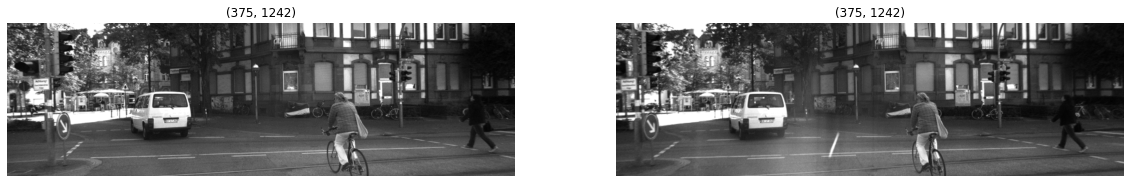

In [38]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
imshow(dataset.get_cam0(0), cmap='gray');
plt.subplot(1,2,2)
imshow(dataset.get_cam1(0), cmap="gray");

In [39]:
# save the left camera images to video
vidname =  f"cam2-{dataset.sequence}.mp4"

if not os.path.exists(vidname):
    videoWriter(dataset.cam2, vidname, fps=10)
else:
    print(f'>> {vidname} already exists, {os.path.getsize(vidname)/1e6:.1f} MB')

>> Saving 154 1242x375 images using avc1
>> wrote 4.4 MB to cam2-00.mp4


In [40]:
Video.from_file(vidname)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00C\xc0Mmdat\x00\x00\…

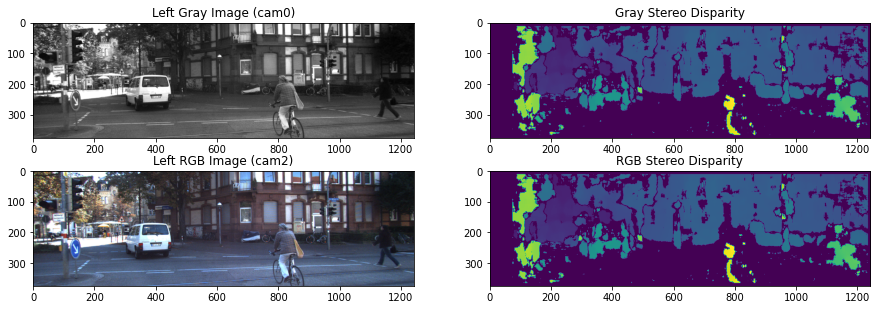

In [130]:
first_gray = dataset.get_gray(0)
first_rgb = dataset.get_rgb(0)

# Do some stereo processing
stereo = cv2.StereoBM_create()
disp_gray = stereo.compute(np.array(first_gray[0]), np.array(first_gray[1]))
disp_rgb = stereo.compute(
    cv2.cvtColor(np.array(first_rgb[0]), cv2.COLOR_RGB2GRAY),
    cv2.cvtColor(np.array(first_rgb[1]), cv2.COLOR_RGB2GRAY))

f, ax = plt.subplots(2, 2, figsize=(15, 5))
ax[0, 0].imshow(first_gray[0], cmap='gray')
ax[0, 0].set_title('Left Gray Image (cam0)')

ax[0, 1].imshow(disp_gray, cmap='viridis')
ax[0, 1].set_title('Gray Stereo Disparity')

ax[1, 0].imshow(first_rgb[0])
ax[1, 0].set_title('Left RGB Image (cam2)')

ax[1, 1].imshow(disp_rgb, cmap='viridis')
ax[1, 1].set_title('RGB Stereo Disparity');

In [149]:
i=0
simgs = []
for left, right in tqdm([x for x in dataset.gray]):
    disp_gray = stereo.compute(np.array(left), np.array(right))
    disp_gray = gray2rgb(disp_gray.astype(dtype="uint8"))
    simgs.append(disp_gray)
    
videoWriter(simgs, "stereo.mp4", fps=10)

100%|█████████████████████████████████████████| 154/154 [00:04<00:00, 35.99it/s]


>> Saving 154 1242x375 images using avc1
>> wrote 4.4 MB to stereo.mp4


In [150]:
Video.from_file("stereo.mp4")

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00C\x80\xbdmdat\x00\x…

## Ground Truth

Where did we really go?

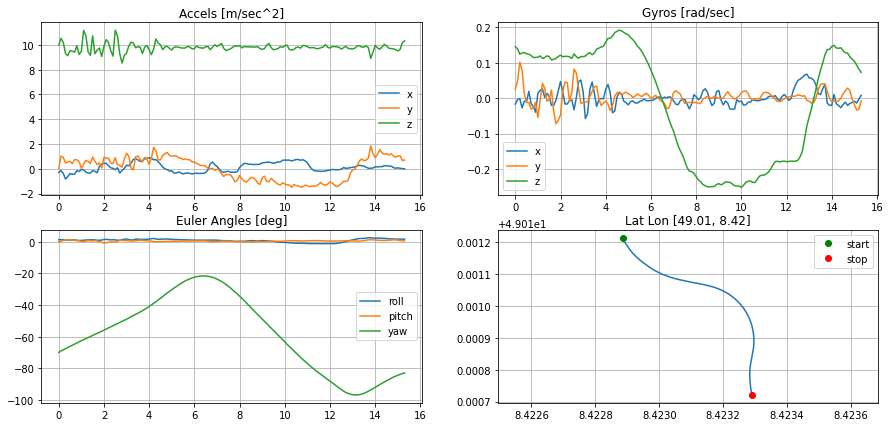

In [80]:
plotSensors(dataset.imu, dataset.oxts, dataset.timestamps)

In [121]:
print("Camera 2")
printCameraParams(dataset.calib.P_rect_20)
print("-"*40)
print("Camera 3")
printCameraParams(dataset.calib.P_rect_30)

Camera 2
Intrinsic Matrix:
[[721.5377   0.     609.5593]
 [  0.     721.5377 172.854 ]
 [  0.       0.       1.    ]]
Rotation Matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Translation Vector:
[-0.0598  0.0004 -0.0027  1.    ]
----------------------------------------
Camera 3
Intrinsic Matrix:
[[721.5377   0.     609.5593]
 [  0.     721.5377 172.854 ]
 [  0.       0.       1.    ]]
Rotation Matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Translation Vector:
[ 0.4729 -0.0024 -0.0027  1.    ]


## Video Odometry



In [102]:
def FAST():
    fast = cv2.FastFeatureDetector_create()
    fast.setNonmaxSuppression(True)
    fast.setThreshold(5)  # 20
    # find and draw the keypoints
    # keypoints = fast.detect(im)
    # keypoints=np.array([[k.pt] for k in keypoints],dtype='f4')  # int?
    
    
    # keypoints = sorted(kp1, key = lambda x:x.response, reverse=True)[:numCorners]
    # keypoints = np.array([k.pt for k in keypoints], dtype='int')
    
    return fast

In [103]:
# This is just a collection of different feature detectors
# def FAST(im):
#     fast = cv2.FastFeatureDetector_create()
#     fast.setNonmaxSuppression(True)
#     fast.setThreshold(5)  # 20
#     # find and draw the keypoints
#     keypoints = fast.detect(im)
#     keypoints=np.array([[k.pt] for k in keypoints],dtype='f4')  # int?
    
    
#     # keypoints = sorted(kp1, key = lambda x:x.response, reverse=True)[:numCorners]
#     # keypoints = np.array([k.pt for k in keypoints], dtype='int')
    
#     return keypoints

def ORB(im):
    # this seems to loose points quickly
    orb = cv2.ORB_create()
    # keypoints = orb.detect(im,None)
    # keypoints=np.array([[k.pt] for k in keypoints],dtype='f4')
    # return keypoints
    return org

def ShiTomasi(im):
    # params for ShiTomasi corner detection
    feature_params = dict( maxCorners = 500,
        qualityLevel = 0.3,
        minDistance = 7,
        blockSize = 7 )
    keypoints = cv2.goodFeaturesToTrack(im, mask = None, **feature_params)
    return keypoints


fast = FAST()
orb = ORB()

def featureDetection(im, method=0):
    """
    This initializes the feature to track OR finds new features when the 
    current group of tracked features falls off the image plane (or said
    anther way, are no longer in the image).
    """
    method = 0
    keypoints = None
    if method == 0:
        # keypoints = FAST(im)
        # find and draw the keypoints
        keypoints = fast.detect(im)
        keypoints=np.array([[k.pt] for k in keypoints], dtype='f4')  # int?
    elif method == 1:
        # keypoints = ORB(im)
        keypoints = orb.detect(im,None)
        keypoints=np.array([[k.pt] for k in keypoints],dtype='f4')
    elif method == 2:
        keypoints = ShiTomasi(im)
    else:
        print('ERROR: no method selected for feature detection')

    return keypoints

In [43]:
def featureTrack(new_gray,old_gray,p0):
    """
    Given some initial feature (p0) find the new location of those 
    features in the new image. All images are grayscale.
    """
    # Parameters for lucas kanade optical flow
    lk_params = dict(
        winSize  = (10,10),
        maxLevel = 3,
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
    )

    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, new_gray, p0, None, **lk_params)

    # good points have st==1, so weed out the bad
    new = p0[st==1]
    old = p1[st==1]
    
    p1 = np.array([[k] for k in new],dtype=np.float32)
    p0 = np.array([[k] for k in old],dtype=np.float32)

    return p0, p1

In [44]:
# def stereo_match_feature(left_img, right_img, patch_radius, keypoints, min_disp, max_disp):
#     # in case you want to find stereo match by yourself
#     h, w = left_img.shape
#     num_points = keypoints.shape[0]

#     # Depth (or disparity) map
#     depth = np.zeros(left_img.shape, np.uint8)
#     output = np.zeros(keypoints.shape, dtype='int')
#     all_index = np.zeros((keypoints.shape[0],1), dtype='int').reshape(-1)

#     r     = patch_radius
#     # patch_size = 2*patch_radius + 1;

#     for i in range(num_points):

#         row, col = keypoints[i,0], keypoints[i,1]
#         # print(row, col)
#         best_offset = 0;
#         best_score = float('inf');

#         if (row-r < 0 or row + r >= h or col - r < 0 or col + r >= w):
#             continue

#         left_patch = left_img[(row-r):(row+r+1), (col-r):(col+r+1)] # left imag patch

#         all_index[i] = 1

#         for offset in range(min_disp, max_disp+1):

#             if (row-r) < 0 or row + r >= h or  (col-r-offset) < 0 or (col+r-offset) >= w:
#                 continue

#             diff = left_patch - right_img[(row-r):(row+r+1), (col-r-offset):(col+r-offset+1)]
#             sum_s = np.sum(diff**2)

#             if sum_s < best_score:
#                 best_score = sum_s
#                 best_offset = offset

#         output[i,0], output[i,1] = row,col-best_offset

#     return output, all_index

In [45]:
def removeDuplicate(queryPoints, refPoints, radius=5):
    #remove duplicate points from new query points,
    for i in range(len(queryPoints)):
        query = queryPoints[i]
        xliml, xlimh = query[0]-radius, query[0]+radius
        yliml, ylimh = query[1]-radius, query[1]+radius
        inside_x_lim_mask = (refPoints[:,0] > xliml) & (refPoints[:,0] < xlimh)
        curr_kps_in_x_lim = refPoints[inside_x_lim_mask]

        if curr_kps_in_x_lim.shape[0] != 0:
            inside_y_lim_mask = (curr_kps_in_x_lim[:,1] > yliml) & (curr_kps_in_x_lim[:,1] < ylimh)
            curr_kps_in_x_lim_and_y_lim = curr_kps_in_x_lim[inside_y_lim_mask,:]
            if curr_kps_in_x_lim_and_y_lim.shape[0] != 0:
                queryPoints[i] =  np.array([0,0])
    return (queryPoints[:, 0]  != 0 )

In [104]:
def extract_keypoints_surf(img1, img2, K, baseline, refPoints = None):
    # detector = cv2.xfeatures2d.SIFT_create(400)
    detector = cv2.SIFT_create(400)
    
    # find keypoints and array of found shapes
    kp1, desc1 = detector.detectAndCompute(img1, None)
    kp2, desc2 = detector.detectAndCompute(img2, None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict()   # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(desc1,desc2,k=2)

    # ratio test as per Lowe's paper
    match_points1, match_points2 = [], []
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.7*n.distance:
            match_points1.append(kp1[m.queryIdx].pt)
            match_points2.append(kp2[m.trainIdx].pt)

    p1 = np.array(match_points1).astype(float)
    p2 = np.array(match_points2).astype(float)

    if refPoints is not None:
        mask = removeDuplicate(p1, refPoints)
        p1 = p1[mask,:]
        p2 = p2[mask,:]

    # 3x4 homogenous matrix for left/right camera
    M_left = K.dot(np.hstack((np.eye(3), np.zeros((3,1)))))
    M_rght = K.dot(np.hstack((np.eye(3), np.array([[-baseline,0, 0]]).T)))
    # rearrange to make function work
    p1_flip = np.vstack((p1.T,np.ones((1,p1.shape[0]))))
    p2_flip = np.vstack((p2.T,np.ones((1,p2.shape[0]))))
    # reconstruct 3d points from camera matrices and points, returns 4xN pts (homogenous)
    P = cv2.triangulatePoints(M_left, M_rght, p1_flip[:2], p2_flip[:2])
    # these are 4d points, convert to 3d by dividing by the last element
    P = P/P[3]
    pts_3d = P[:3]

    return pts_3d.T, p1

In [105]:
def featureTracking(img_1, img_2, p1, world_points):
    # use KLT tracker
    lk_params = dict( winSize  = (21,21),
                      maxLevel = 3,
                      criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))

    p2, st, err = cv2.calcOpticalFlowPyrLK(img_1, img_2, p1, None, **lk_params)
    st = st.reshape(st.shape[0])
    # find good one
    pre = p1[st==1]
    p2 = p2[st==1]
    w_points = world_points[st==1]  # ??????

    return w_points, pre,p2

In [127]:
def run(images, K, baseline):
    '''
        different ways to initialize the query points and landmark points
        you can specify the keypoints and landmarks
        or you can inilize_3D with FAST corner points, then stereo match and 
        then generate 3D points, but not so accurate
        or you can use the OPENCV feature extraction and matching functions
    '''
    failed = 0
    ret_pos = []
    left_img, right_img = images[0]

    points, p1 = extract_keypoints_surf(left_img, right_img, K, baseline)
    p1 = p1.astype('float32')

    # pnp_objP = np.expand_dims(points, axis = 2)
    # pnp_p1   = np.expand_dims(p1, axis = 2).astype(float)

    # reference
    reference_img = left_img
    reference_2D  = p1
    landmark_3D   = points

    # _, rvec, tvec = cv2.solvePnP(pnp_objP, pnp_p1, K, None)

    # for i, (left_img, right_img) in enumerate(tqdm(images)):
    for left_img, _ in tqdm(images[1:]):

        # track points through left image
        landmark_3D, reference_2D, tracked_2Dpoints = featureTracking(
            reference_img, 
            left_img, # curImage, 
            reference_2D,  
            landmark_3D)
        # print(len(landmark_3D), len(valid_land_mark))

        pnp_objP = np.expand_dims(landmark_3D, axis = 2)
        pnp_cur  = np.expand_dims(tracked_2Dpoints, axis = 2).astype(float)

        # try to estimate object pose given current image points
        _, rvec, tvec, inliers = cv2.solvePnPRansac(pnp_objP , pnp_cur, K, None)

        # update the new reference_2D
        reference_2D = tracked_2Dpoints[inliers[:,0],:]
        landmark_3D  = landmark_3D[inliers[:,0],:]

        # retrieve the rotation matrix
        rot,_ = cv2.Rodrigues(rvec)
        tvec = -rot.T.dot(tvec)     # coordinate transformation, from camera to world

        inv_transform = np.hstack((rot.T,tvec)) # inverse transform

        inliers_ratio = len(inliers)/len(pnp_objP) # the inlier ratio
#         print('inliers ratio: ',inliers_ratio)

        # re-obtain the 3 D points if the conditions satisfied
        # calculate distance tracked keypoints have moved
        if (inliers_ratio < 0.9 or len(reference_2D) < 500):
            # initiliazation new landmarks
            
            # landmark_3D, reference_2D = initiliazatize_3D_points(curImage, 
            #   curImage_R, K, baseline)
            # reference_2D = np.fliplr(reference_2D).astype('float32')
            
            landmark_3D_new, reference_2D_new = extract_keypoints_surf(
                left_img,   #curImage, 
                right_img,  # curImage_R, 
                K, 
                baseline, 
                reference_2D)
            # ???
            reference_2D_new = reference_2D_new.astype('float32')
            landmark_3D_new = inv_transform.dot(
                np.vstack((landmark_3D_new.T, np.ones((1,landmark_3D_new.shape[0]))))
            )
            valid_matches = landmark_3D_new[2,:] > 0
            landmark_3D_new = landmark_3D_new[:,valid_matches]

            reference_2D = np.vstack((reference_2D, reference_2D_new[valid_matches,:]))
            landmark_3D =  np.vstack((landmark_3D, landmark_3D_new.T))
        else:
            failed += 1

        reference_img = left_img
        ret_pos.append((tvec[0], tvec[2]))
    
    print(f"Failed conditions {failed} times")
    return ret_pos

## Run Odometry

Now this isn't fast and takes some time. Ideally you should probably code this in C++ for improved speed once you get the algorithm working here.

In [85]:
# this can take a little bit, so put it on its own
imgs = [x for x in dataset.gray]

In [128]:
K = dataset.calib.K_cam2
baseline = 0.54
pts = run(imgs, K, baseline)

 37%|███████████████▋                          | 57/153 [00:12<00:20,  4.70it/s]


TypeError: 'NoneType' object is not subscriptable

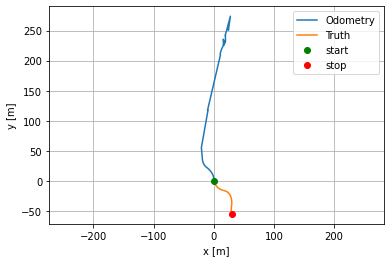

In [97]:
cx = [x[0] for x in pts]
cy = [x[1] for x in pts]
plt.plot(cx, cy, label='Odometry')

# get the ground truth from GPS
tx = []
ty = []

# use the first point as the origin/start
slat = dataset.oxts[0].packet.lat
slon = dataset.oxts[0].packet.lon

for d in dataset.oxts:
    a = d.packet.lat
    b = d.packet.lon
    xx,yy = ll2xy(a,b,slat,slon)
    tx.append(xx)
    ty.append(yy)

tx = np.array(tx)
ty = np.array(ty)

plt.plot(tx,ty, label='Truth')
plt.plot(tx[0],ty[0],"go", label="start")
plt.plot(tx[-1],ty[-1],"ro", label="stop")

plt.grid(True)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('equal')
plt.legend();

In [75]:
from math import sqrt
def calcError(calc, truex, truey):
    ret = []
    for (cx, cy), tx, ty in zip(calc, truex, truey):
        err = sqrt((tx - cx)**2 + (ty - cy)**2)
        ret.append(err)
    return max(ret), ret

In [76]:
max_err, err = calcError(pts, tx, ty)

Text(0.5, 1.0, 'Odometry Error\nMax Error: 165.0m over 6.9km or 2.4%')

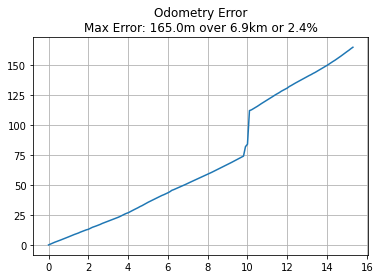

In [77]:
dist = sum([sqrt(x[0]**2 + x[1]**2) for x in pts])
plt.plot(dataset.timestamps, err)
plt.grid(True)
plt.title(f'Odometry Error\nMax Error: {max_err:.1f}m over {dist/1000:.1f}km or {100*(max_err/dist):.1f}%')

In [124]:
help(cv2.calcOpticalFlowPyrLK)

Help on built-in function calcOpticalFlowPyrLK:

calcOpticalFlowPyrLK(...)
    calcOpticalFlowPyrLK(prevImg, nextImg, prevPts, nextPts[, status[, err[, winSize[, maxLevel[, criteria[, flags[, minEigThreshold]]]]]]]) -> nextPts, status, err
    .   @brief Calculates an optical flow for a sparse feature set using the iterative Lucas-Kanade method with
    .   pyramids.
    .   
    .   @param prevImg first 8-bit input image or pyramid constructed by buildOpticalFlowPyramid.
    .   @param nextImg second input image or pyramid of the same size and the same type as prevImg.
    .   @param prevPts vector of 2D points for which the flow needs to be found; point coordinates must be
    .   single-precision floating-point numbers.
    .   @param nextPts output vector of 2D points (with single-precision floating-point coordinates)
    .   containing the calculated new positions of input features in the second image; when
    .   OPTFLOW_USE_INITIAL_FLOW flag is passed, the vector must have the 

In [116]:
help(cv2.decomposeProjectionMatrix)

Help on built-in function decomposeProjectionMatrix:

decomposeProjectionMatrix(...)
    decomposeProjectionMatrix(projMatrix[, cameraMatrix[, rotMatrix[, transVect[, rotMatrixX[, rotMatrixY[, rotMatrixZ[, eulerAngles]]]]]]]) -> cameraMatrix, rotMatrix, transVect, rotMatrixX, rotMatrixY, rotMatrixZ, eulerAngles
    .   @brief Decomposes a projection matrix into a rotation matrix and a camera intrinsic matrix.
    .   
    .   @param projMatrix 3x4 input projection matrix P.
    .   @param cameraMatrix Output 3x3 camera intrinsic matrix \f$\cameramatrix{A}\f$.
    .   @param rotMatrix Output 3x3 external rotation matrix R.
    .   @param transVect Output 4x1 translation vector T.
    .   @param rotMatrixX Optional 3x3 rotation matrix around x-axis.
    .   @param rotMatrixY Optional 3x3 rotation matrix around y-axis.
    .   @param rotMatrixZ Optional 3x3 rotation matrix around z-axis.
    .   @param eulerAngles Optional three-element vector containing three Euler angles of rotation in
